In [1]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [2]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

In [3]:
def convert_degree_to_radian(n):
    return n / 180 * np.pi

In [4]:
# Read animation parameters

def read_file(path):

    with open(path) as f:
        lines = f.readlines()

    dof_angles = []
    for line in lines:
        string_list = line.split()
        float_list = []
        for item in string_list:
            radian_value = convert_degree_to_radian(float(item))
            float_list.append(radian_value)
        dof_angles.append(float_list)

    return dof_angles



In [116]:
class Leg(object):
  """A 3-DoF leg with position actuators."""
  def __init__(self, length, rgba):
    self.model = mjcf.RootElement()

    # Defaults:
    self.model.default.joint.damping = 3
    self.model.default.joint.type = 'hinge'
    self.model.default.geom.type = 'capsule'
    self.model.default.geom.rgba = rgba

    # Bone 1:
    self.bone1 = self.model.worldbody.add('body', pos=[0, 0, 0])
    self.joint1 = self.bone1.add('joint', axis=[0, 1, 0])
    self.bone1.add('geom', fromto=[0, 0, 0, 0, 0, length], size=[length/20])

    # Bone 2:
    self.bone2 = self.bone1.add('body', pos=[0, 0, length])
    self.joint2 = self.bone2.add('joint', axis=[0, 1, 0])
    self.bone2.add('geom', fromto=[0, 0, 0, 0, 0, length], size=[length/20])

    # Bone 3:
    self.bone3 = self.bone2.add('body', pos=[0, 0, length])
    self.joint3 = self.bone3.add('joint', axis=[0, 1, 0])
    self.bone3.add('geom', fromto=[0, 0, 0, 0, 0, length], size=[length/20])

    # Position actuators:
    self.model.actuator.add('position', joint=self.joint1, kp=10)
    self.model.actuator.add('position', joint=self.joint2, kp=10)
    self.model.actuator.add('position', joint=self.joint3, kp=10)


In [38]:
class LegAndAngles(object):
  """A 3-DoF leg with position actuators."""
  def __init__(self, length, rgba, angles, leg_mass):
    self.model = mjcf.RootElement()

    # Defaults:
    self.model.default.joint.damping = 3
    self.model.default.joint.type = 'hinge'
    self.model.default.geom.type = 'capsule'
    self.model.default.geom.rgba = rgba

    # Bone 1:
    self.bone1 = self.model.worldbody.add('body', pos=[0, 0, 0], euler=angles[0])
    self.joint1 = self.bone1.add('joint', axis=[0, 1, 0])
    self.bone1.add('geom', fromto=[0, 0, 0, 0, 0, length], size=[length/20], mass=leg_mass)

    # Bone 2:
    self.bone2 = self.bone1.add('body', pos=[0, 0, length], euler=angles[1])
    self.joint2 = self.bone2.add('joint', axis=[0, 1, 0])
    self.bone2.add('geom', fromto=[0, 0, 0, 0, 0, length], size=[length/20], mass=leg_mass)

    # Bone 3:
    self.bone3 = self.bone2.add('body', pos=[0, 0, length], euler=angles[2])
    self.joint3 = self.bone3.add('joint', axis=[0, 1, 0])
    self.bone3.add('geom', fromto=[0, 0, 0, 0, 0, length], size=[length/20], mass=leg_mass)

    # Position actuators:
    self.model.actuator.add('position', joint=self.joint1, kp=10)
    self.model.actuator.add('position', joint=self.joint2, kp=10)
    self.model.actuator.add('position', joint=self.joint3, kp=10)


In [117]:
class Spine(object):
    def __init__(self, length, rgba):
        self.model = mjcf.RootElement()

        # Defaults:
        self.model.default.joint.damping = 4
        self.model.default.joint.type = 'hinge'
        self.model.default.geom.type = 'capsule'
        self.model.default.geom.rgba = rgba

        # Bone 1:
        self.bone1 = self.model.worldbody.add('body', pos=[0, 0, 0])
        self.joint1 = self.bone1.add('joint', axis=[0, 1, 0])
        self.bone1.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Bone 2:
        self.bone2 = self.bone1.add('body', pos=[length, 0, 0])
        self.joint2 = self.bone2.add('joint', axis=[0, 1, 0])
        self.bone2.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])
        
        front_leg = Leg(length, rgba)
        front_leg_site = self.bone2.add('site', pos=[0, 0, 0], euler=[np.pi/4, np.pi/10, 0])
        front_leg_site.attach(front_leg.model)
        
        rear_leg = Leg(length, rgba)
        rear_leg_site = self.bone2.add('site', pos=[0, 0, 0], euler=[-np.pi/4, np.pi/10, 0])
        rear_leg_site.attach(rear_leg.model)

        # Bone 3:
        self.bone3 = self.bone2.add('body', pos=[length, 0, 0])
        self.joint3 = self.bone3.add('joint', axis=[0, 1, 0])
        self.bone3.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Bone 4:
        self.bone4 = self.bone3.add('body', pos=[length, 0, 0])
        self.joint4 = self.bone4.add('joint', axis=[0, 1, 0])
        self.bone4.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Position actuators:
        self.model.actuator.add('position', joint=self.joint1, kp=10)
        self.model.actuator.add('position', joint=self.joint2, kp=10)
        self.model.actuator.add('position', joint=self.joint3, kp=10)
        self.model.actuator.add('position', joint=self.joint4, kp=10)


In [118]:
class HeadSpine():
    def __init__(self, length, rgba):
        self.model = mjcf.RootElement()

        # Defaults:
        self.model.default.joint.damping = 4
        self.model.default.joint.type = 'hinge'
        self.model.default.geom.type = 'capsule'
        self.model.default.geom.rgba = rgba 

        # Bone 1:
        self.bone1 = self.model.worldbody.add('body', pos=[0, 0, 0])
        self.joint1 = self.bone1.add('joint', axis=[0, 1, 0])
        self.bone1.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])
        

        # Bone 2:
        self.bone2 = self.bone1.add('body', pos=[length, 0, 0])
        self.joint2 = self.bone2.add('joint', axis=[0, 1, 0])
        self.bone2.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Bone 3:
        self.bone3 = self.bone2.add('body', pos=[length, 0, 0])
        self.joint3 = self.bone3.add('joint', axis=[0, 1, 0])
        self.bone3.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        front_leg = Leg(length, rgba)
        front_leg_site = self.bone3.add('site', pos=[0, 0, 0], euler=[np.pi/4, np.pi/10, 0])
        front_leg_site.attach(front_leg.model)
        
        rear_leg = Leg(length, rgba)
        rear_leg_site = self.bone3.add('site', pos=[0, 0, 0], euler=[-np.pi/4, np.pi/10, 0])
        rear_leg_site.attach(rear_leg.model)

        # Bone 4:
        self.bone4 = self.bone3.add('body', pos=[length, 0, 0])
        self.joint4 = self.bone4.add('joint', axis=[0, 1, 0])
        self.bone4.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Position actuators:
        self.model.actuator.add('position', joint=self.joint1, kp=10)
        self.model.actuator.add('position', joint=self.joint2, kp=10)
        self.model.actuator.add('position', joint=self.joint3, kp=10)
        self.model.actuator.add('position', joint=self.joint4, kp=10)


In [119]:
class HeadSpineTest():
    def __init__(self, length, rgba):
        self.model = mjcf.RootElement()

        # Defaults:
        self.model.default.joint.damping = 4
        self.model.default.joint.type = 'hinge'
        self.model.default.geom.type = 'capsule'
        self.model.default.geom.rgba = rgba 

        # Bone 1:
        self.bone1 = self.model.worldbody.add('body', pos=[0, 0, 0], euler=[np.pi/4, np.pi/4, np.pi/4])
        self.joint1 = self.bone1.add('joint', axis=[0, 1, 0])
        self.bone1.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Bone 2:
        self.bone2 = self.bone1.add('body', pos=[length, 0, 0], euler=[np.pi/4, np.pi/4, np.pi/4])
        self.joint2 = self.bone2.add('joint', axis=[0, 1, 0])
        self.bone2.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Bone 3:
        self.bone3 = self.bone2.add('body', pos=[length, 0, 0])
        self.joint3 = self.bone3.add('joint', axis=[0, 1, 0])
        self.bone3.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        front_leg = Leg(length, rgba)
        front_leg_site = self.bone3.add('site', pos=[0, 0, 0], euler=[np.pi/4, np.pi/10, 0])
        front_leg_site.attach(front_leg.model)
        
        rear_leg = Leg(length, rgba)
        rear_leg_site = self.bone3.add('site', pos=[0, 0, 0], euler=[-np.pi/4, np.pi/10, 0])
        rear_leg_site.attach(rear_leg.model)

        # Bone 4:
        self.bone4 = self.bone3.add('body', pos=[length, 0, 0])
        self.joint4 = self.bone4.add('joint', axis=[0, 1, 0])
        self.bone4.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Position actuators:
        self.model.actuator.add('position', joint=self.joint1, kp=10)
        self.model.actuator.add('position', joint=self.joint2, kp=10)
        self.model.actuator.add('position', joint=self.joint3, kp=10)
        self.model.actuator.add('position', joint=self.joint4, kp=10)


In [126]:
class TailSpine():
    def __init__(self, length, rgba):
        self.model = mjcf.RootElement()

        # Defaults:
        self.model.default.joint.damping = 4
        self.model.default.joint.type = 'hinge'
        self.model.default.geom.type = 'capsule'
        self.model.default.geom.rgba = rgba  # Continued below...

        # Bone 1:
        self.bone1 = self.model.worldbody.add('body', pos=[0, 0, 0])
        self.joint1 = self.bone1.add('joint', axis=[0, 1, 0])
        self.bone1.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Bone 2:
        self.bone2 = self.bone1.add('body', pos=[length, 0, 0])
        self.joint2 = self.bone2.add('joint', axis=[0, 1, 0])
        self.bone2.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])
        
        front_leg = Leg(length, rgba)
        front_leg_site = self.bone2.add('site', pos=[0, 0, 0], euler=[np.pi/4, np.pi/10, 0])
        front_leg_site.attach(front_leg.model)
        
        rear_leg = Leg(length, rgba)
        rear_leg_site = self.bone2.add('site', pos=[0, 0, 0], euler=[-np.pi/4, np.pi/10, 0])
        rear_leg_site.attach(rear_leg.model)

        # Bone 3:
        self.bone3 = self.bone2.add('body', pos=[length, 0, 0])
        self.joint3 = self.bone3.add('joint', axis=[0, 1, 0])
        self.bone3.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Bone 4:
        self.bone4 = self.bone3.add('body', pos=[length, 0, 0])
        self.joint4 = self.bone4.add('joint', axis=[0, 1, 0])
        self.bone4.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10])

        # Position actuators:
        self.model.actuator.add('position', joint=self.joint1, kp=10)
        self.model.actuator.add('position', joint=self.joint2, kp=10)
        self.model.actuator.add('position', joint=self.joint3, kp=10)
        self.model.actuator.add('position', joint=self.joint4, kp=10)


In [39]:
class FullSpine():
    def __init__(self, length, rgba, angles, bone_mass_list):
        self.model = mjcf.RootElement()
        self.model.compiler.angle = 'radian'

        # Defaults:
        self.model.default.joint.damping = 4
        self.model.default.joint.type = 'hinge'
        self.model.default.geom.type = 'capsule'
        self.model.default.geom.rgba = rgba

        spine_angles = []
        left_front_leg = []
        right_front_leg = []
        left_rear_leg = []
        right_rear_leg = []


        for body_angle in range(0, 8):
            spine_angles.append(angles[body_angle])

        for left_front_angle in range(8, 11):
            left_front_leg.append(angles[left_front_angle])
        
        for right_front_angle in range(11, 14):
            right_front_leg.append(angles[right_front_angle])

        for right_rear_angle in range(14, 17):
            right_rear_leg.append(angles[right_rear_angle])

        for left_rear_angle in range(17, 20):
            left_rear_leg.append(angles[left_rear_angle])

        spine_bone_mass = bone_mass_list[0]
        left_front_leg_mass = bone_mass_list[1]
        right_front_leg_mass = bone_mass_list[2]
        left_rear_leg_mass = bone_mass_list[3]
        right_rear_leg_mass = bone_mass_list[4]
        
        # Bone 1:
        self.bone1 = self.model.worldbody.add('body', pos=[0, 0, 0], euler=spine_angles[0])
        self.joint1 = self.bone1.add('joint', axis=[0, 1, 0])
        self.bone1.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10], mass=spine_bone_mass)


        # Bone 2:
        self.bone2 = self.bone1.add('body', pos=[length, 0, 0], euler=spine_angles[1])
        self.joint2 = self.bone2.add('joint', axis=[0, 1, 0])
        self.bone2.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10], mass=spine_bone_mass)

        # Bone 3:
        self.bone3 = self.bone2.add('body', pos=[length, 0, 0], euler=spine_angles[2])
        self.joint3 = self.bone3.add('joint', axis=[0, 1, 0])
        self.bone3.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10], mass=spine_bone_mass)

        # Bone 4:
        self.bone4 = self.bone3.add('body', pos=[length, 0, 0], euler=spine_angles[3])
        self.joint4 = self.bone4.add('joint', axis=[0, 1, 0])
        self.bone4.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10], mass=spine_bone_mass)

        front_right = LegAndAngles(0.12, rgba, right_front_leg, right_front_leg_mass)
        # front_leg_site = self.bone3.add('site', pos=[0, 0, 0], euler=[np.pi/4, np.pi/10, 0])
        front_leg_site = self.bone4.add('site', pos=[0, 0, 0], euler=[np.pi/4, 0, 0])
        front_leg_site.attach(front_right.model)
        
        front_left = LegAndAngles(0.12, rgba, left_front_leg, left_front_leg_mass)
        # rear_leg_site = self.bone3.add('site', pos=[0, 0, 0], euler=[-np.pi/4, np.pi/10, 0])
        rear_leg_site = self.bone4.add('site', pos=[0, 0, 0], euler=[-np.pi/4, 0, 0])
        rear_leg_site.attach(front_left.model)

        # Bone 5:
        self.bone5 = self.bone4.add('body', pos=[length, 0, 0], euler=spine_angles[4])
        self.joint5 = self.bone1.add('joint', axis=[0, 1, 0])
        self.bone5.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10], mass=spine_bone_mass)

        # Bone 6:
        self.bone6 = self.bone5.add('body', pos=[length, 0, 0], euler=spine_angles[5])
        self.joint6 = self.bone6.add('joint', axis=[0, 1, 0])
        self.bone6.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10], mass=spine_bone_mass)

        # Bone 7:
        self.bone7 = self.bone6.add('body', pos=[length, 0, 0], euler=spine_angles[6])
        self.joint7 = self.bone7.add('joint', axis=[0, 1, 0])
        self.bone7.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10], mass=spine_bone_mass)

        rear_left = LegAndAngles(length, rgba, left_rear_leg, left_rear_leg_mass)
        front_leg_site = self.bone7.add('site', pos=[0, 0, 0], euler=[-np.pi/4, 0, 0])
        front_leg_site.attach(rear_left.model)
        
        rear_right = LegAndAngles(length, rgba, right_rear_leg, right_rear_leg_mass)
        rear_leg_site = self.bone7.add('site', pos=[0, 0, 0], euler=[np.pi/4, 0, 0])
        rear_leg_site.attach(rear_right.model)

        # Bone 8:
        self.bone8 = self.bone7.add('body', pos=[length, 0, 0], euler=spine_angles[7])
        self.joint8 = self.bone8.add('joint', axis=[0, 1, 0])
        self.bone8.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/10], mass=spine_bone_mass)


        # Position actuators:
        self.model.actuator.add('position', joint=self.joint1, kp=10)
        self.model.actuator.add('position', joint=self.joint2, kp=10)
        self.model.actuator.add('position', joint=self.joint3, kp=10)
        self.model.actuator.add('position', joint=self.joint4, kp=10)
        self.model.actuator.add('position', joint=self.joint5, kp=10)
        self.model.actuator.add('position', joint=self.joint6, kp=10)
        self.model.actuator.add('position', joint=self.joint7, kp=10)
        self.model.actuator.add('position', joint=self.joint8, kp=10)

In [40]:
def make_horse(length, rgba, angles, bone_mass_list):
   
    # model = mjcf.RootElement()
    # model.compiler.angle = 'radian'

    # right_spine_site = model.worldbody.add('site', euler=[0, -np.pi/10, 0])
    # left_spine_site = model.worldbody.add('site', euler=[0, np.pi/10, np.pi])
    # spine_head = HeadSpineTest(length, rgba)
    # spine_tail = TailSpine(length, rgba)
    # right_spine_site.attach(spine_head.model)
    # left_spine_site.attach(spine_tail.model)
    # return model

    model = mjcf.RootElement()
    model.compiler.angle = 'radian'

    animal_site = model.worldbody.add('site', euler=[0, 0, 0])
    full_horse_body = FullSpine(length, rgba, angles, bone_mass_list)
    animal_site.attach(full_horse_body.model)

    return model
    

In [49]:
time_stamp_1 = [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0], 
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]]
len(time_stamp_1)

20

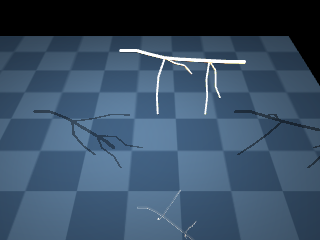

In [59]:
# Render

arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])

test_angles = []
for i in range(0, 20):
  test_angles.append([0, 0, 0])
# angles = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
# creature = make_horse(0.1, [4, 3, 2, 1], time_stamp_1)
angles = read_file('animation_params/arti_params_11.txt')

def make_first_angle_zeros(angle_list):
  angle_list[0] = [0, 0, 0]
  return angle_list


def move_angles_by_one(angle_list):
  angle_list.insert(0, [0, 0, 0])
  return angle_list
  
def body_only_angles(angle_list):
  body_only = []
  for i in range(0, 21):
    if i > 8:
      body_only.append([0, 0, 0])
    else:
      body_only.append(angles[i])

  print(body_only)
  return body_only

bone_masses = [0.12, 0.12, 0.12, 0.1, 0.1]
# creature = make_horse(0.1, [4, 3, 2, 1], move_angles_by_one(angles), bone_masses)
creature = make_horse(0.1, [4, 3, 2, 1], time_stamp_1, bone_masses)


# Place them on a grid in the arena.
height = .15
grid = 5 * 2
xpos, ypos, zpos = np.meshgrid([-grid, 0, grid], [0, grid], [height])

# item_pos = (xpos.flat[1], ypos.flat[1], zpos.flat[1])
item_pos = [0, 0, 1]
item_site = arena.worldbody.add('site', pos=item_pos, euler=[np.pi, 0, 0])
item_site.attach(creature)
# item_site.attach(creature).add('freejoint')
# leg_site.attach(leg.model).add('freejoint')

# for i, model in enumerate(creatures):
#   # Place spawn sites on a grid.
#   spawn_pos = (xpos.flat[i], ypos.flat[i], zpos.flat[i])
#   spawn_site = arena.worldbody.add('site', pos=spawn_pos, group=3)
#   # Attach to the arena at the spawn sites, with a free joint.
#   spawn_site.attach(model).add('freejoint')

# Instantiate the physics and render.
physics = mjcf.Physics.from_mjcf_model(arena)
PIL.Image.fromarray(physics.render())

In [114]:
image = PIL.Image.fromarray(physics.render())

# Save the image
name = "horse0"
image.save('./horse_images/'+ name + '.png')
np.save(name+'.npy', time_stamp_1)

In [16]:
duration = 30   # (Seconds)
framerate = 30  # (Hz)
video = []
actuators = creature.find_all('actuator')

# Control signal frequency, phase, amplitude.
freq = 6
phase = np.pi * 3
amp = 1.1

# Simulate, saving video frames and torso locations.
physics.reset()
while physics.data.time < duration:
  # Inject controls and step the physics.
  # front legs
  physics.bind(actuators[4:7]).ctrl = amp * np.sin(freq * physics.data.time + phase)
  physics.bind(actuators[7:10]).ctrl = amp * np.sin(freq * physics.data.time + phase)
  # front spine
  physics.bind(actuators[:4]).ctrl = amp * np.sin(freq * physics.data.time) / 6
  # back legs
  physics.bind(actuators[14:17]).ctrl = amp * np.sin(freq * physics.data.time)
  physics.bind(actuators[17:20]).ctrl = amp * np.sin(freq * physics.data.time)
  # back spine
  physics.bind(actuators[len(actuators)//2:len(actuators)//2+4]).ctrl = amp * np.sin(freq * physics.data.time) /4
  physics.step()

  # Save video frames.
  if len(video) < physics.data.time * framerate:
    pixels = physics.render()
    video.append(pixels.copy())

display_video(video, framerate)

PhysicsError: Physics state is invalid. Warning(s) raised: mjWARN_INERTIA

In [ ]:
len(actuators)

20